# Clothing Review Sentiment Analysis
## Introduction
In this project, we analyze customer reviews from an e-commerce dataset to uncover insights about product sentiment. Using both **TextBlob** and **VADER** sentiment analysis tools, we categorize reviews as Positive, Neutral, or Negative, and evaluated for consistency. Based on comparison, TextBlob was selected for generating business-relevant insights.

The goal of this project is to simulate how businesses can leverage automated sentiment analysis to monitor product perception and customer satisfaction.


## Data Loading And Initial Exploration
Started the project by importing libraries I would need and taking an initial look at its structure, size, and sample entries.


In [3]:
#!pip install textblob
#nltk.download('vader_lexicon')


# Import & Load Data (CSV File)
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [4]:
df= pd.read_csv('Womens Clothing E-Commerce Reviews.csv')

# Peek at data
print(df.shape)
df.head()

(23486, 11)


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


## Data Cleaning

Before performing sentiment analysis, I cleaned the data by:
- Dropping irrelevant columns
- Handling missing values
- Removing rows with empty reviews
- Dropping Duplicates
- Reset The Index

This ensures the sentiment analysis is based on meaningful, usable text data.


In [5]:
#Remove Duplicatrs,if any
df=df.drop_duplicates()

#Remove the Unnamed:0 Column,Division Name,Class Name serves no function for the project
df=df.drop(columns=["Unnamed: 0","Division Name","Class Name","Title"])
df

,Clothing ID,Age,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimate
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses
2,1077,60,I had such high hopes for this dress and reall...,3,0,0,Dresses
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms
4,847,47,This shirt is very flattering to all due to th...,5,1,6,Tops
...,...,...,...,...,...,...,...
23481,1104,34,I was very happy to snag this dress at such a ...,5,1,0,Dresses
23482,862,48,"It reminds me of maternity clothes. soft, stre...",3,1,0,Tops
23483,1104,31,"This fit well, but the top was very see throug...",3,0,1,Dresses
23484,1084,28,I bought this dress for a wedding i have this ...,3,1,2,Dresses


In [6]:
#Replace the NAN values
#Confirm if there is NAN Values anywehre else
df.isnull().sum()

# Remove NAN Values found in "Review Text","Department Name"
df=df.fillna('')

#Remove Rows With Empty Review Text, AI can't analyze what is not available to it
for x in df.index:
    if df.loc[x,"Review Text"] == '':
        df.drop(x,inplace=True)

for x in df.index:
    if df.loc[x,"Department Name"].strip() == '':
        df.loc[x,"Department Name"] = "Unknown"
 
## Side Note: Anothet Way To Drop Null Values
#df.dropna(subset="Review Text"), inplace=True)

#Reset Index
df= df.reset_index(drop=True)
df

,Clothing ID,Age,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimate
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses
2,1077,60,I had such high hopes for this dress and reall...,3,0,0,Dresses
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms
4,847,47,This shirt is very flattering to all due to th...,5,1,6,Tops
...,...,...,...,...,...,...,...
22636,1104,34,I was very happy to snag this dress at such a ...,5,1,0,Dresses
22637,862,48,"It reminds me of maternity clothes. soft, stre...",3,1,0,Tops
22638,1104,31,"This fit well, but the top was very see throug...",3,0,1,Dresses
22639,1084,28,I bought this dress for a wedding i have this ...,3,1,2,Dresses


## Exploratory Data Analysis (EDA)

To understand the dataset better, I visualized:
- Star rating distribution
- Reviewed text length distribution


Identified the number of unique products in the dataset. Having Over 1000+ Clothes should reflect a diverse product range

In [7]:
#Rating & Product Distribution

#Product Distributions
df['Clothing ID'].nunique()

1179

In [8]:
#Rating Distribution
rating_pt= df["Rating"].value_counts(normalize=True).sort_index()*100
rating_pt


Rating
1     3.626165
2     6.841571
3    12.468531
4    21.677488
5    55.386246
Name: proportion, dtype: float64

**Side-Note:** 
A right-skewed distribution with most ratings in the 4-5 range.
It is a good enough distribution, might need to group ratings in the 1-3 as"negative", 4-5 as "positive"(if needed)

### Rating Distribution Visualization

To better understand overall customer satisfaction, we visualize the percentage distribution of product ratings from the reviews dataset.

The bar chart below displays the proportion of reviews for each rating (1 to 5 stars). Added percentage labels on top of each bar to make it easy to interpret.

### **Business Insight:**  
- A high percentage of 4-5 star reviews suggests most customers are satisfied with their purchases, which is a positive indicator for the product and the brand.  
- However,the proportion of 1-2 star reviews may highlight potential product quality issues or unmet customer expectations that require further investigation.


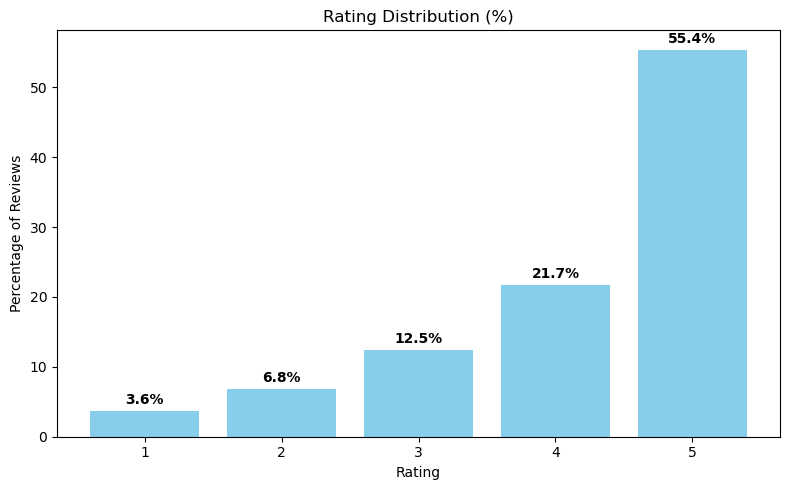

In [9]:
# Histogram Plot
plt.figure(figsize=(8, 5))
plt.bar(rating_pt.index, rating_pt.values, color='skyblue')
plt.title('Rating Distribution (%)')
plt.xlabel('Rating')
plt.ylabel('Percentage of Reviews')

#Percentage labels
for i, v in enumerate(rating_pt.values):
    plt.text(rating_pt.index[i], v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### Cleaning The Review Text
Cleaning review text improves the accuracy for sentiment analysis and text-based insights. This ensures that business decisions around product improvements, customer service strategies, or marketing messages are based on reliable, structured data rather than noisy, inconsistent input.

Although TextBlob does not need me to strictly celan the text to run, but I decided to clean it to help improve the accuracy and reliability of the dataset.

In [10]:
def clean_text(text):
    if pd.isna(text) or text == '' :
        return ''
        
    # Convert to lowercase
    text = text.lower()
    
    # Expand Contractions
    contractions = {
            "won't": "will not", "can't": "cannot", "n't": " not",
            "'re": " are", "'ve": " have", "'ll": " will",
            "'d": " would", "'m": " am", "it's": "it is",
            "that's": "that is", "what's": "what is"
    }
    for contraction, expansion in contractions.items():
            text = text.replace(contraction, expansion)
        
    # Removes extra whitespace and newlines
    text = re.sub(r'\s+', ' ', text)
    
    # Removes punctuation but keep sentence structure
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove numbers 
    text = re.sub(r'\d+', '', text)
    return text


df['newText']=df['Review Text'].apply(clean_text)
df

,Clothing ID,Age,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,newText
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimate,absolutely wonderful silky and sexy and comf...
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,love this dress it is sooo pretty i happened...
2,1077,60,I had such high hopes for this dress and reall...,3,0,0,Dresses,i had such high hopes for this dress and reall...
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,i love love love this jumpsuit it is fun f...
4,847,47,This shirt is very flattering to all due to th...,5,1,6,Tops,this shirt is very flattering to all due to th...
...,...,...,...,...,...,...,...,...
22636,1104,34,I was very happy to snag this dress at such a ...,5,1,0,Dresses,i was very happy to snag this dress at such a ...
22637,862,48,"It reminds me of maternity clothes. soft, stre...",3,1,0,Tops,it reminds me of maternity clothes soft stre...
22638,1104,31,"This fit well, but the top was very see throug...",3,0,1,Dresses,this fit well but the top was very see throug...
22639,1084,28,I bought this dress for a wedding i have this ...,3,1,2,Dresses,i bought this dress for a wedding i have this ...


### Review Length Distribution Visualisation

The review length distribution indicates that customers are generally providing detailed feedback, especially around the 40 and 100-word range. 

This presents a valuable opportunity for the business to extract rich insights from customer reviews through sentiment analysis and text mining, guiding product improvements and enhancing customer experience.


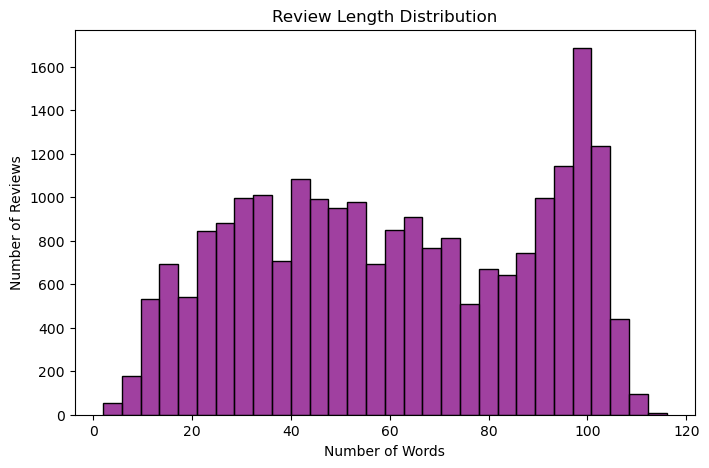

In [11]:
#Review Length
df['review_length']=df['newText'].apply(lambda x: len(x.split()))

# Plot review length distribution
plt.figure(figsize=(8,5))
sns.histplot(df['review_length'], bins=30, color='purple')
plt.title('Review Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.show()


## Sentiment Analysis with TextBlob

TextBlob provides a simple polarity score ranging from -1 (negative) to 1 (positive). We convert these scores into categorical sentiment labels:
- **Positive**: Polarity > 0.1
- **Neutral**: Polarity between -0.1 and 0.1
- **Negative**: Polarity < -0.1

In [12]:
def analyze_sentiment(text):
    blob=TextBlob(str(text))
    polarity=blob.sentiment.polarity


    if polarity > 0.1:
        return 'positive', 'good'
    elif polarity < -0.1:
        return 'negative', 'bad'
    else:
        return 'neutral','neutral'

df[['blobSentiment','blobLabel']] = df['newText'].apply(
    lambda x:pd.Series(analyze_sentiment(x))
)
df

,Clothing ID,Age,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,newText,review_length,blobSentiment,blobLabel
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimate,absolutely wonderful silky and sexy and comf...,7,positive,good
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,love this dress it is sooo pretty i happened...,64,positive,good
2,1077,60,I had such high hopes for this dress and reall...,3,0,0,Dresses,i had such high hopes for this dress and reall...,97,neutral,neutral
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,i love love love this jumpsuit it is fun f...,23,positive,good
4,847,47,This shirt is very flattering to all due to th...,5,1,6,Tops,this shirt is very flattering to all due to th...,36,positive,good
...,...,...,...,...,...,...,...,...,...,...,...
22636,1104,34,I was very happy to snag this dress at such a ...,5,1,0,Dresses,i was very happy to snag this dress at such a ...,29,positive,good
22637,862,48,"It reminds me of maternity clothes. soft, stre...",3,1,0,Tops,it reminds me of maternity clothes soft stre...,38,neutral,neutral
22638,1104,31,"This fit well, but the top was very see throug...",3,0,1,Dresses,this fit well but the top was very see throug...,44,positive,good
22639,1084,28,I bought this dress for a wedding i have this ...,3,1,2,Dresses,i bought this dress for a wedding i have this ...,87,positive,good


## Sentiment Analysis with VADER

VADER is optimized for social media and product reviews, offering a compound sentiment score from -1 to 1. Similar to TextBlob, we apply thresholds to assign categorical sentiment labels.


In [13]:
vader =SentimentIntensityAnalyzer()

def analyze_sentiment_vader(text):
    score = vader.polarity_scores(str(text))['compound'] 

    if score > 0.1:
        return 'positive', 'good'
    elif score < -0.1:
        return 'negative', 'bad'
    else:
        return 'neutral', 'neutral'

df[['sentimentVader', 'labelVader']] = df['newText'].apply(
    lambda x: pd.Series(analyze_sentiment_vader(x))
)
df

,Clothing ID,Age,Review Text,Rating,Recommended IND,Positive Feedback Count,Department Name,newText,review_length,blobSentiment,blobLabel,sentimentVader,labelVader
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimate,absolutely wonderful silky and sexy and comf...,7,positive,good,positive,good
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,love this dress it is sooo pretty i happened...,64,positive,good,positive,good
2,1077,60,I had such high hopes for this dress and reall...,3,0,0,Dresses,i had such high hopes for this dress and reall...,97,neutral,neutral,positive,good
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Bottoms,i love love love this jumpsuit it is fun f...,23,positive,good,positive,good
4,847,47,This shirt is very flattering to all due to th...,5,1,6,Tops,this shirt is very flattering to all due to th...,36,positive,good,positive,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22636,1104,34,I was very happy to snag this dress at such a ...,5,1,0,Dresses,i was very happy to snag this dress at such a ...,29,positive,good,positive,good
22637,862,48,"It reminds me of maternity clothes. soft, stre...",3,1,0,Tops,it reminds me of maternity clothes soft stre...,38,neutral,neutral,positive,good
22638,1104,31,"This fit well, but the top was very see throug...",3,0,1,Dresses,this fit well but the top was very see throug...,44,positive,good,positive,good
22639,1084,28,I bought this dress for a wedding i have this ...,3,1,2,Dresses,i bought this dress for a wedding i have this ...,87,positive,good,positive,good


## Comparison: TextBlob vs. VADER

To evaluate the consistency between the two sentiment tools:
- Create a crosstab comparison
- Visualize agreement and discrepancies using a heatmap

This highlights the strengths and limitations of both approaches for sentiment analysis.


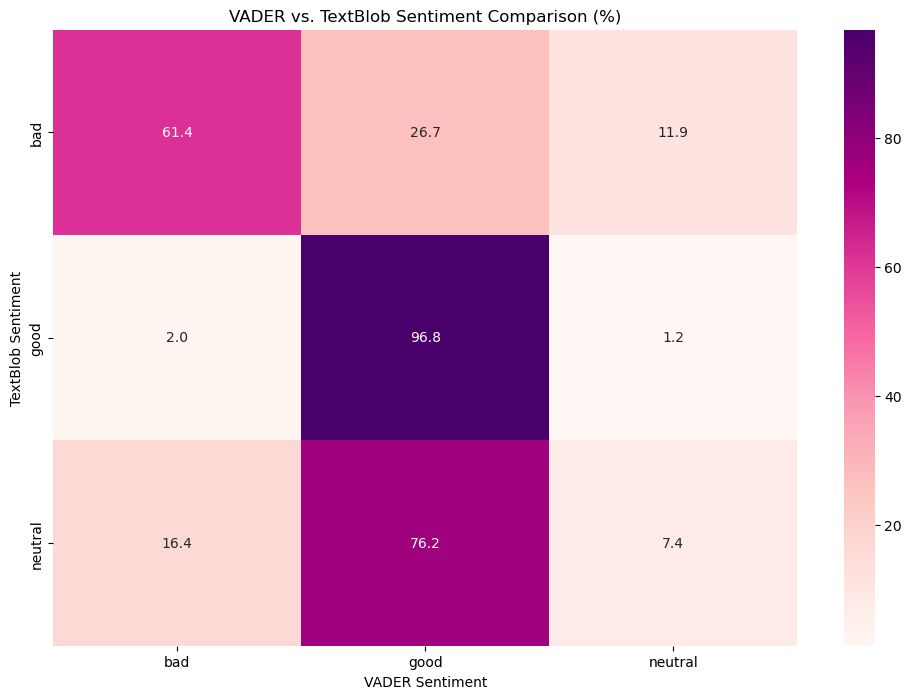

In [25]:
crosstab = pd.crosstab(df['blobLabel'],df['labelVader'], normalize='index') * 100

plt.figure(figsize=(12,8))
sns.heatmap(crosstab, annot=True, fmt=".1f", cmap="RdPu")
plt.title("VADER vs. TextBlob Sentiment Comparison (%)")
plt.ylabel("TextBlob Sentiment")
plt.xlabel("VADER Sentiment")
plt.show()

### Sentiment Analysis Tool Comparison: VADER vs. TextBlob

To assess the reliability of our sentiment analysis, we compared the sentiment labels generated by two different tools: **TextBlob** and **VADER**. The heatmap above illustrates how often these tools agree or disagree in classifying the same set of customer reviews.

Each cell represents the percentage of reviews falling into each sentiment combination:

- Rows represent **TextBlob** sentiment classifications.  
- Columns represent **VADER** sentiment classifications.  
- Higher percentages along the diagonal indicate agreement between the tools.  

### **Key Business Insights:**

- There is a **strong agreement on positive sentiment**, with **96.8%** of reviews marked as "good" by TextBlob also being classified as "good" by VADER. This suggests that both tools reliably detect satisfied customers, which is valuable for marketing, product promotion, and reputation management.

- However, for **negative sentiment**, agreement drops to **61.4%**, with **26.7%** of those reviews being marked as "good" by VADER. This inconsistency could lead to underestimating customer dissatisfaction if relying on a single tool, potentially masking product or service issues.

- The classification of **neutral sentiment** also shows moderate disagreement, highlighting how borderline reviews are interpreted differently by each tool. This introduces risk when analyzing ambiguous feedback or tracking subtle changes in customer sentiment.

### **Business Limitations:**

While both tools are useful, relying on only one may produce misleading sentiment insights, especially for negative or neutral feedback. For critical decision-making, such as identifying areas for product improvement or detecting potential churn risk, it is recommended to:

- Use both tools in combination.  
- Flag reviews with tool disagreement for manual review.

After tesing both analyzers, TextBlob gave more consistent result for this dataset. So I'm going to use TextBlob to uncover deeper business insights on this dataset.

## TextBlob Sentiment Distribution


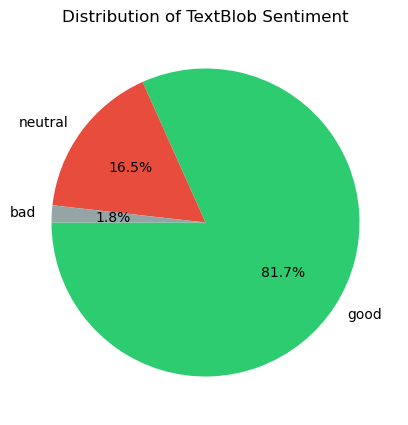

In [15]:
text_counts=df["blobLabel"].value_counts()
plt.figure(figsize=(5,5))
colors=['#2ecc71', '#e74c3c', '#95a5a6']#green,red,gray
plt.pie(text_counts.values,labels=text_counts.index, autopct='%1.1f%%', colors=colors, startangle=180)
plt.title('Distribution of TextBlob Sentiment')
plt.show()

## TextBlob Sentiment By Department

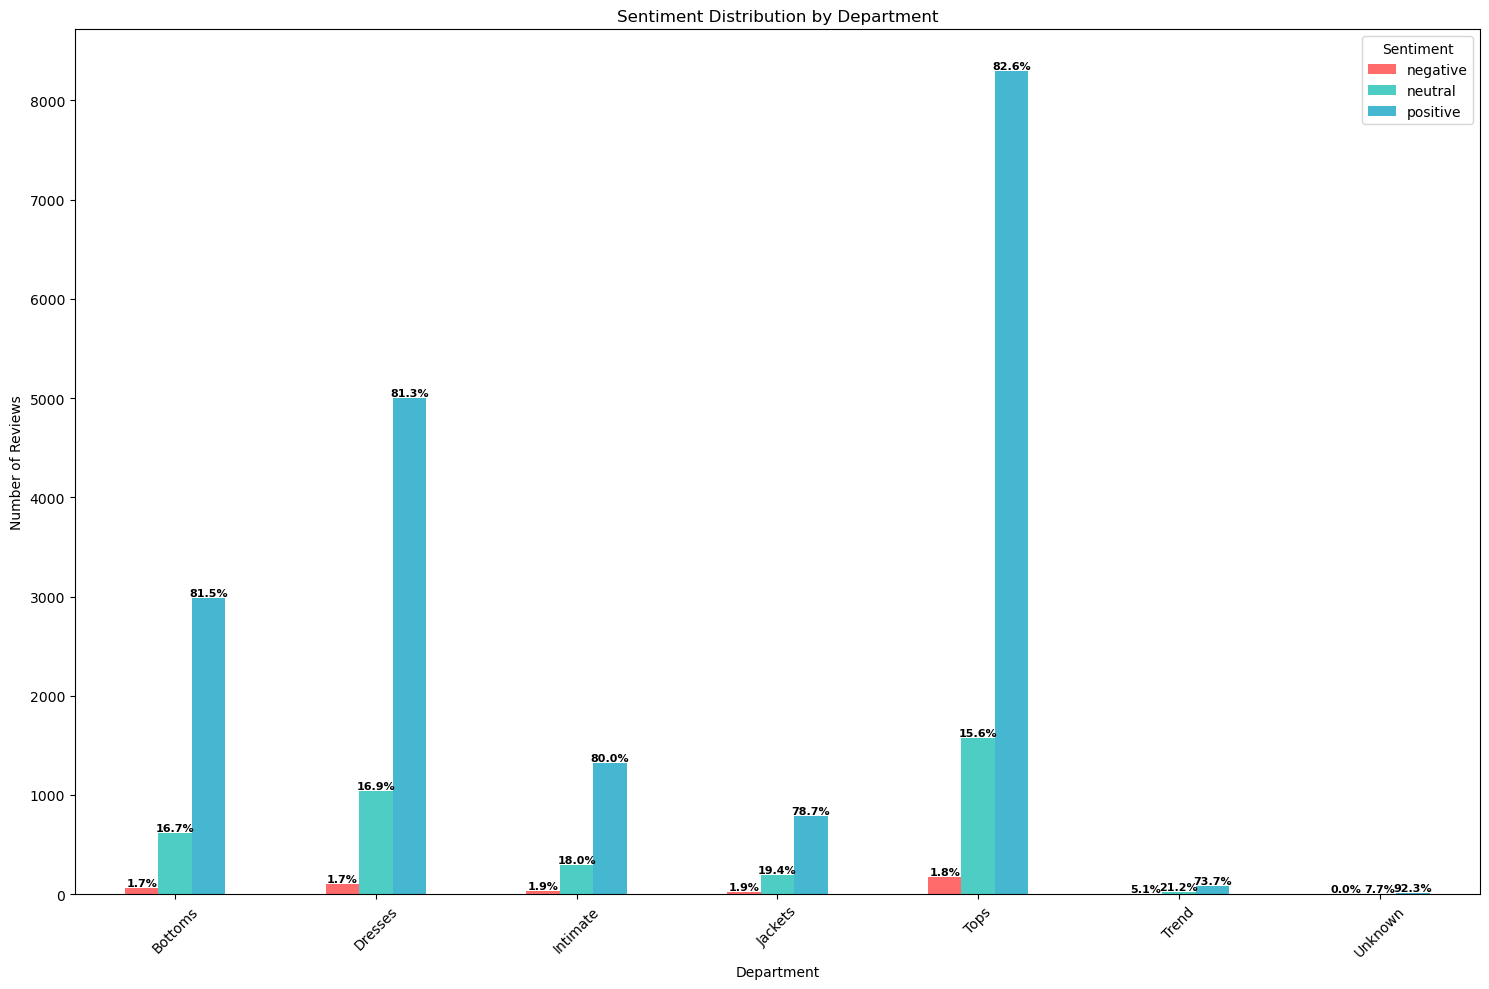

In [16]:
sentiment_dept = df.groupby(['Department Name', 'blobSentiment']).size().unstack(fill_value=0)
sentiment_pct = sentiment_dept.div(sentiment_dept.sum(axis=1), axis=0) * 100

ax = sentiment_dept.plot(kind='bar', figsize=(15, 10), color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
for container, col in zip(ax.containers, sentiment_pct.columns):
    ax.bar_label(container, labels=[f'{pct:.1f}%' for pct in sentiment_pct[col]], 
                fontweight='bold', fontsize=8)

ax.set(title='Sentiment Distribution by Department', xlabel='Department', ylabel='Number of Reviews')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()



## TextBlob Sentiment by Age Group

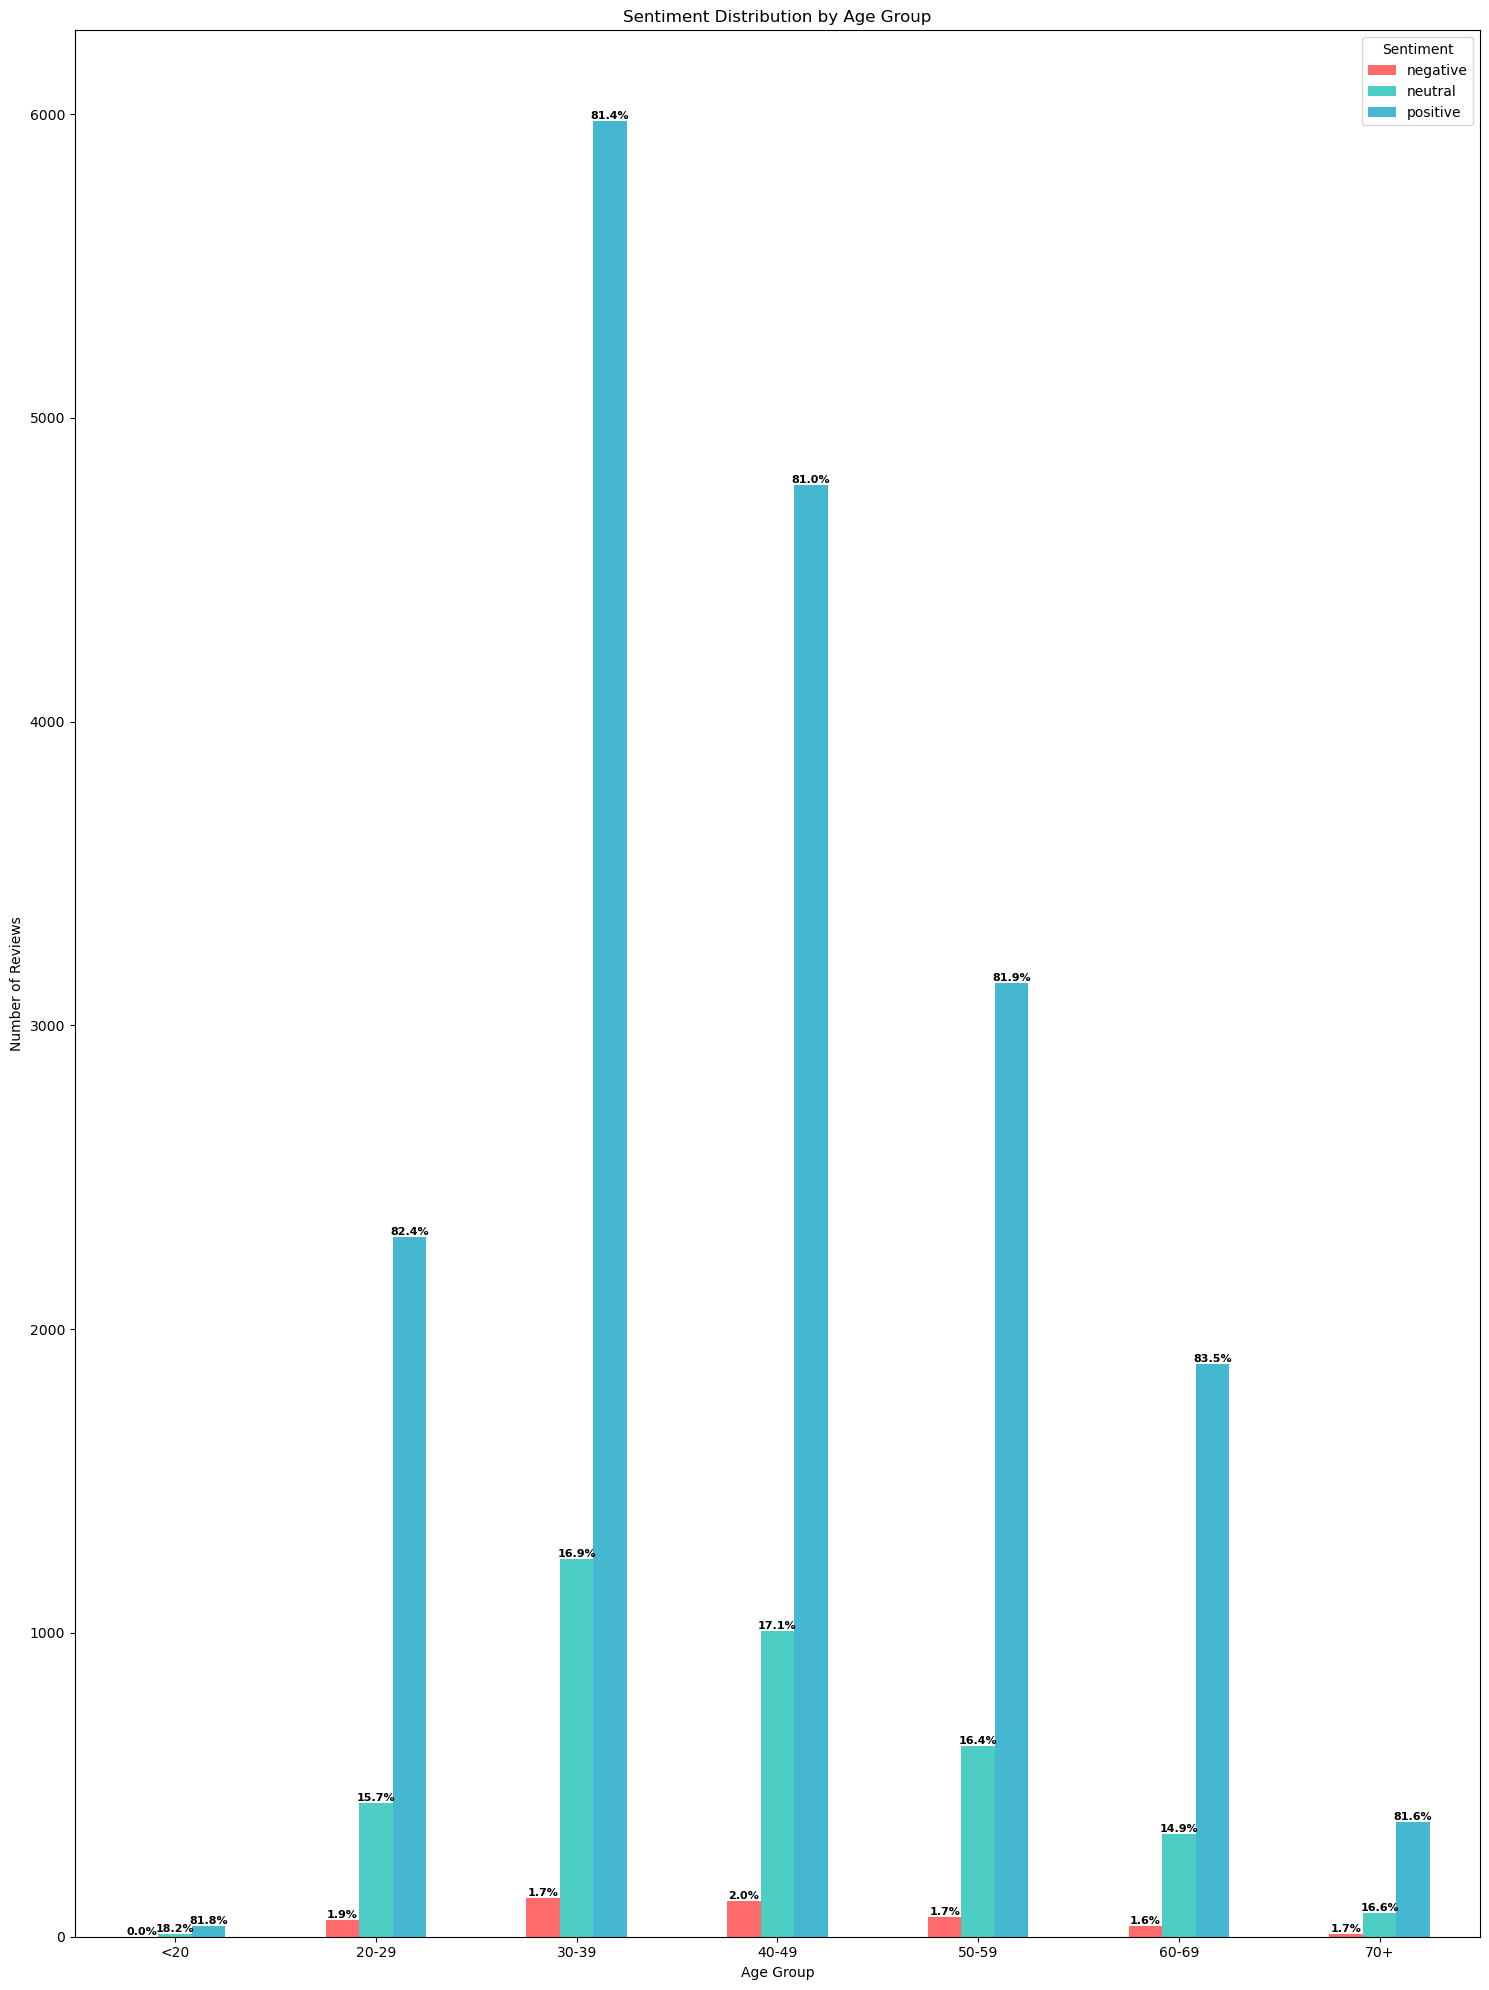

In [17]:
# Create age groups and analyze sentiment in fewer lines
df['Age Group'] = pd.cut(df['Age'], bins=[0, 20, 30, 40, 50, 60, 70, 100], 
                        labels=['<20', '20-29', '30-39', '40-49', '50-59', '60-69', '70+'], 
                        right=False)

sentiment_age = df.groupby(['Age Group', 'blobSentiment'], observed=True).size().unstack(fill_value=0)
sentiment_age_pct = sentiment_age.div(sentiment_age.sum(axis=1), axis=0) * 100

# Create plot with percentage labels
ax = sentiment_age.plot(kind='bar', figsize=(15,20), color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
for container, col in zip(ax.containers, sentiment_age_pct.columns):
    ax.bar_label(container, labels=[f'{pct:.1f}%' for pct in sentiment_age_pct[col]], 
                fontweight='bold', fontsize=8)

# Style the plot
ax.set(title='Sentiment Distribution by Age Group', xlabel='Age Group', ylabel='Number of Reviews')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


## TextBlob Sentiment by Star Rating

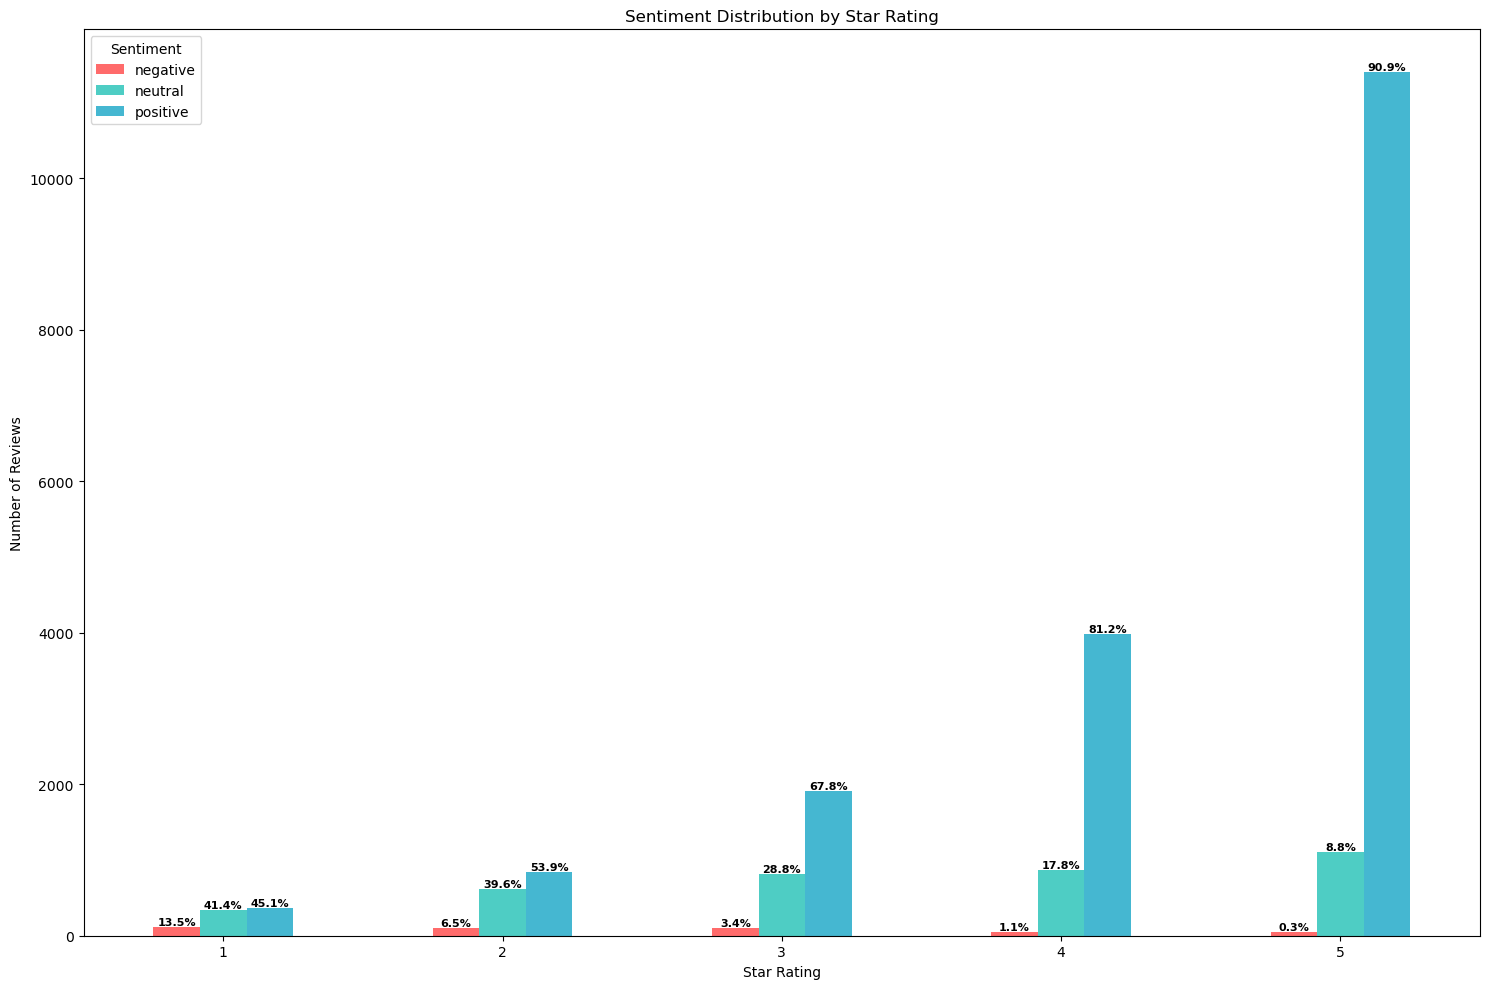

In [18]:
# Streamlined sentiment analysis by rating
sentiment_rating = df.groupby(['Rating', 'blobSentiment']).size().unstack(fill_value=0)
sentiment_rating_pct = sentiment_rating.div(sentiment_rating.sum(axis=1), axis=0) * 100

# Create plot with percentage labels
ax = sentiment_rating.plot(kind='bar', figsize=(15, 10), color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
for container, col in zip(ax.containers, sentiment_rating_pct.columns):
    ax.bar_label(container, labels=[f'{pct:.1f}%' for pct in sentiment_rating_pct[col]], 
                fontweight='bold', fontsize=8)

# Style the plot
ax.set(title='Sentiment Distribution by Star Rating', xlabel='Star Rating', ylabel='Number of Reviews')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

## Review Length vs Star Rating

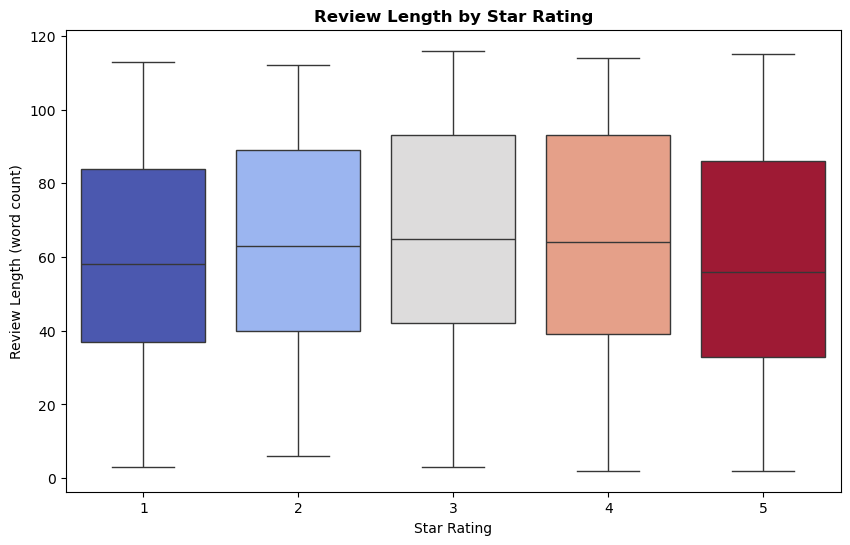

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Rating', y='review_length',hue='Rating', palette='coolwarm', legend=False)
plt.title('Review Length by Star Rating', fontweight='bold')
plt.xlabel('Star Rating')
plt.ylabel('Review Length (word count)')
plt.show()

## Voice of Customer Heatmap

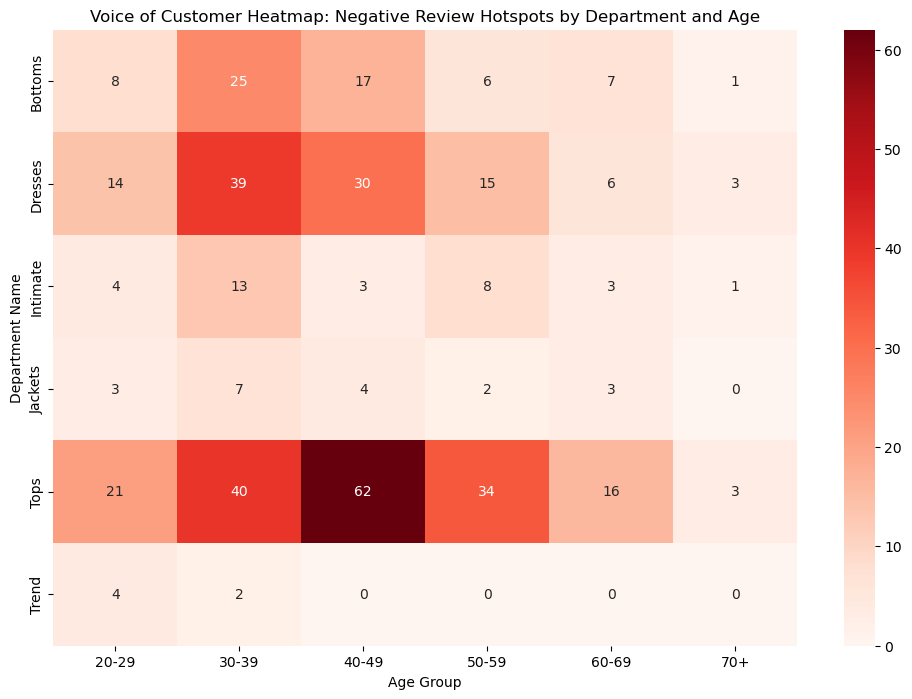

In [24]:
negative_reviews_df = df[df['blobSentiment'] == 'negative']

customer_heatmap_data = negative_reviews_df.groupby(['Department Name', 'Age Group'], observed=True).size().unstack(fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(customer_heatmap_data, annot=True, cmap='Reds', )
plt.title('Voice of Customer Heatmap: Negative Review Hotspots by Department and Age')
plt.xlabel('Age Group')
plt.ylabel('Department Name')
plt.show()

## Key Business Recommendations

1. **Investigate the "Top" Department**: The "Trend" department shows a significantly higher proportion of negative reviews (15.5%) compared to other departments like "Dresses" (8.5%) and "Tops" (9.7%).But the heatmap reveals that the "Tops" department generates the highest absolute number of negative reviews. The most significant complaint hotspots are:
- Tops from the 30-39 age group (40 negative reviews).
- Tops from the 40-49 age group (62 negative reviews).


The business should prioritize investigating the root causes of this dissatisfaction. This could involve analyzing product quality, sizing inconsistencies, or misleading product descriptions specific to this department.

2. **Leverage Positive Feedback for Marketing**: With over 81% of reviews classified as positive, the marketing team has a rich source of user-generated content. Detailed, positive reviews, especially from the highly-satisfied 40-49 age group, can be used for testimonials on product pages, social media campaigns, and other promotional materials to build trust and drive sales.
3. **Analyze Negative Reviews for Product Improvement**: While fewer in number, the negative reviews are crucial for improvement. The analysis shows that 1-star reviews tend to be longer, indicating that highly dissatisfied customers provide specific details. A dedicated team should analyze these reviews to identify recurring themes (e.g., "fabric," "sizing," "see-through") and provide direct feedback to design and production teams.

## Conclusion

This project successfully demonstrates the value of automated sentiment analysis in transforming raw customer reviews into actionable business intelligence. The analysis confirmed that customer sentiment is **overwhelmingly positive**, which is a strong indicator of brand health and product satisfaction.

The selection of TextBlob as the primary analysis tool was validated by its strong correlation with star ratings, providing a reliable method for categorizing feedback at scale. Key insights were uncovered, most notably the underperformance of the "Top" department, which requires immediate attention to address a higher-than-average rate of negative customer feedback.